# Part 0 - Getting libraries and download the source data

#### First we import all the libraries required to run the project

In [1]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import os
import shutil
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import pipeline

In [2]:
!pip install hf_xet

#### Then we download two data sources from Kaggle and store in project folder

In [3]:
# Download from KaggleHub 
src = kagglehub.dataset_download("datafiniti/consumer-reviews-of-amazon-products")

# Your desired subfolder in the current working directory
dst = r"C:\Users\alexa\OneDrive\Documents\Machine Learning Repos\Imperial\Module 25\ic_ai_course_capstone_submission\CRM data"
os.makedirs(dst, exist_ok=True)

# Copy everything over
shutil.copytree(src, dst, dirs_exist_ok=True)
print("Files for dataset 1 copied to:", dst,"from: ",src)

Files for dataset 1 copied to: C:\Users\alexa\OneDrive\Documents\Machine Learning Repos\Imperial\Module 25\ic_ai_course_capstone_submission\CRM data from:  C:\Users\alexa\.cache\kagglehub\datasets\datafiniti\consumer-reviews-of-amazon-products\versions\5


In [4]:
# Download from KaggleHub 
src = kagglehub.dataset_download("innocentmfa/crm-sales-opportunities")

# Your desired subfolder in the current working directory
dst = r"C:\Users\alexa\OneDrive\Documents\Machine Learning Repos\Imperial\Module 25\ic_ai_course_capstone_submission\CRM data"
os.makedirs(dst, exist_ok=True)

# Copy everything over
shutil.copytree(src, dst, dirs_exist_ok=True)
print("Files for dataset 2 copied to:", dst,"from: ",src)

Files for dataset 2 copied to: C:\Users\alexa\OneDrive\Documents\Machine Learning Repos\Imperial\Module 25\ic_ai_course_capstone_submission\CRM data from:  C:\Users\alexa\.cache\kagglehub\datasets\innocentmfa\crm-sales-opportunities\versions\1


# Part 1 - Reviewing the data

#### First let's review CRM data...

In [5]:
file_path = os.path.join(dst, "accounts.csv")
accounts_data = pd.read_csv(file_path)
file_path = os.path.join(dst, "data_dictionary.csv")
data_dictionary_data = pd.read_csv(file_path)
file_path = os.path.join(dst, "products.csv")
products_data = pd.read_csv(file_path)
file_path = os.path.join(dst, "sales_pipeline.csv")
sales_pipeline_data = pd.read_csv(file_path)
file_path = os.path.join(dst, "sales_teams.csv")
sales_teams_data = pd.read_csv(file_path)

In [6]:
accounts_data.head()

,account,sector,year_established,revenue,employees,office_location,subsidiary_of
0,Acme Corporation,technolgy,1996,1100.04,2822,United States,NaN
1,Betasoloin,medical,1999,251.41,495,United States,NaN
2,Betatech,medical,1986,647.18,1185,Kenya,NaN
3,Bioholding,medical,2012,587.34,1356,Philipines,NaN
4,Bioplex,medical,1991,326.82,1016,United States,NaN


In [7]:
data_dictionary_data.head()

,Table,Field,Description
0,accounts,account,Company name
1,accounts,sector,Industry
2,accounts,year_established,Year Established
3,accounts,revenue,Annual revenue (in millions of USD)
4,accounts,employees,Number of employees


In [8]:
products_data.head()

,product,series,sales_price
0,GTX Basic,GTX,550
1,GTX Pro,GTX,4821
2,MG Special,MG,55
3,MG Advanced,MG,3393
4,GTX Plus Pro,GTX,5482


In [9]:
products_data["product"].unique()

array(['GTX Basic', 'GTX Pro', 'MG Special', 'MG Advanced',
       'GTX Plus Pro', 'GTX Plus Basic', 'GTK 500'], dtype=object)

In [10]:
sales_pipeline_data.head()

,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01,1054.0
1,Z063OYW0,Darcel Schlecht,GTXPro,Isdom,Won,2016-10-25,2017-03-11,4514.0
2,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07,50.0
3,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09,588.0
4,PE84CX4O,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02,517.0


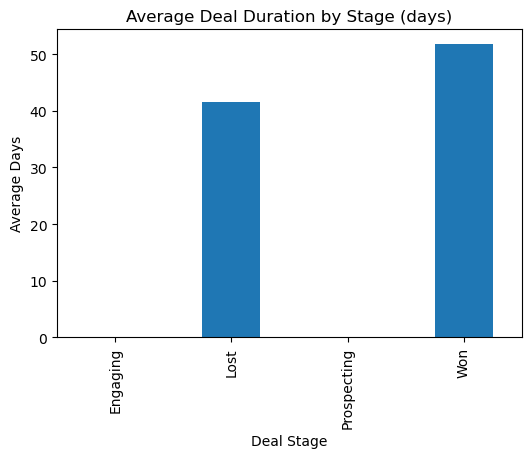

In [11]:
# Convert to datetime
df=sales_pipeline_data
df["engage_date"] = pd.to_datetime(df["engage_date"])
df["close_date"] = pd.to_datetime(df["close_date"], errors="coerce")  # NaT if still open
df["duration_days"] = (df["close_date"] - df["engage_date"]).dt.days

# -----------------------------
# 1. Average time for each deal_stage
avg_time = df.groupby("deal_stage")["duration_days"].mean()

avg_time.plot(kind="bar", figsize=(6,4))
plt.title("Average Deal Duration by Stage (days)")
plt.ylabel("Average Days")
plt.xlabel("Deal Stage")
plt.show()

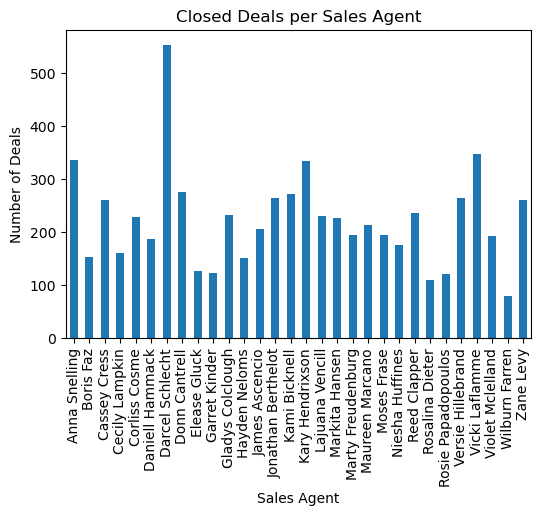

In [12]:
# 3. Number of closed deals per sales agent
closed_deals = df[df["deal_stage"].isin(["Won","Lost"])]  # adjust if you have other closed stages

closed_deals.groupby("sales_agent")["opportunity_id"].count().plot(
    kind="bar", figsize=(6,4)
)
plt.title("Closed Deals per Sales Agent")
plt.ylabel("Number of Deals")
plt.xlabel("Sales Agent")
plt.show()


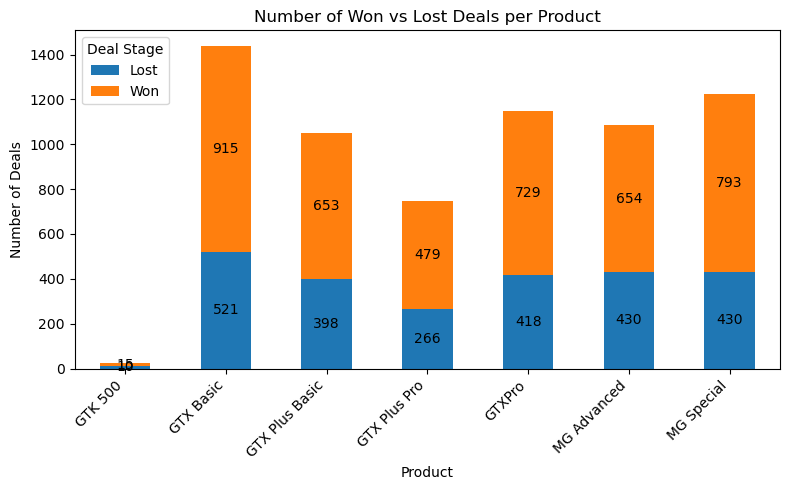

In [13]:

# 4. Number of Won/Lost deals per product
deal_counts = (
    df[df["deal_stage"].isin(["Won","Lost"])]
    .groupby(["product","deal_stage"])["opportunity_id"]
    .count()
    .unstack(fill_value=0)
)
pd.set_option("display.max_colwidth", 10)
ax = deal_counts.plot(kind="bar", stacked=True, figsize=(8,5))

plt.title("Number of Won vs Lost Deals per Product")
plt.ylabel("Number of Deals")
plt.xlabel("Product")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Deal Stage")

# --- Add numbers on the bars ---
for container in ax.containers:
    ax.bar_label(container, label_type="center")  # 'center' or 'edge'

plt.tight_layout()
plt.show()

In [14]:
deal_counts["Total"] = deal_counts["Lost"] + deal_counts["Won"]
deal_counts = deal_counts.sort_values(by="Total", ascending=False)
deal_counts 

deal_stage,Lost,Won,Total
product,,,
GTX Basic,521,915,1436
MG Special,430,793,1223
GTXPro,418,729,1147
MG Advanced,430,654,1084
GTX Plus Basic,398,653,1051
GTX Plus Pro,266,479,745
GTK 500,10,15,25


#### Secondly let's review customer feedback data...

In [15]:
file_path = os.path.join(dst, "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")
CRM_client_reviews = pd.read_csv(file_path)

In [16]:
CRM_client_reviews.head()

,name,brand,categories,primaryCategories,imageURLs,keys,manufacturer,reviews.date,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username
0,Fire T...,Amazon,Electr...,Electr...,https:...,084871...,Amazon,2018-0...,2019-0...,True,NaN,NaN,1.0,5,https:...,Pros: ...,Fire s...,John Z.
1,Fire T...,Amazon,Electr...,Electr...,https:...,084871...,Amazon,2018-0...,2019-0...,True,NaN,NaN,1.0,5,https:...,Pros: ...,Great ...,Anonymous
2,Fire T...,Amazon,Electr...,Electr...,https:...,084871...,Amazon,2019-0...,2019-0...,True,NaN,NaN,1.0,5,https:...,Pros: ...,GREAT!...,Larry T.
3,Fire T...,Amazon,Electr...,Electr...,https:...,084871...,Amazon,2019-0...,2019-0...,True,NaN,NaN,1.0,5,https:...,Pros: ...,"Quick,...",Camero...
4,Fire T...,Amazon,Electr...,Electr...,https:...,084871...,Amazon,2018-0...,2019-0...,True,NaN,NaN,1.0,5,https:...,Pros: ...,Should...,Anonymous


In [17]:
#CRM_client_reviews["name"].value_counts()
products = CRM_client_reviews["name"].value_counts().reset_index(name="count").rename(columns={"index":"deal_stage"})
products.head(7)

,name,count
0,Fire H...,2443
1,All-Ne...,2370
2,Fire K...,1676
3,Fire K...,1425
4,Fire K...,1212
5,Fire T...,1024
6,Fire T...,987


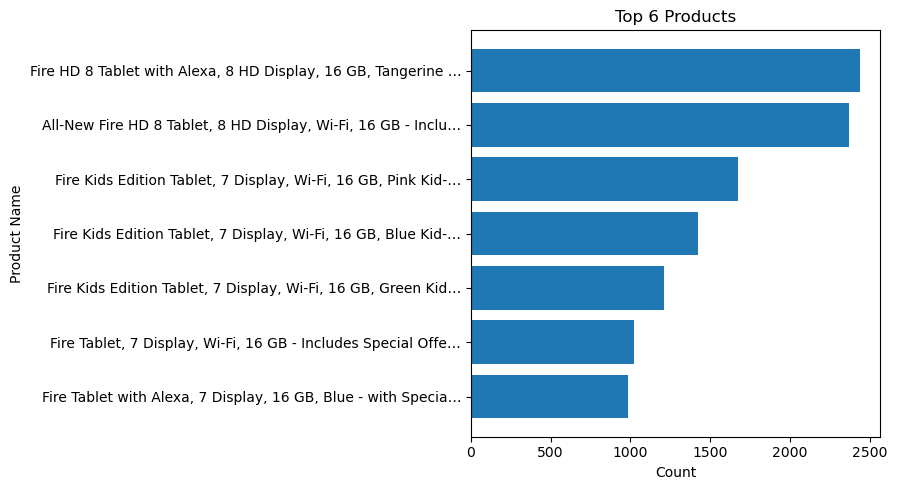

In [18]:
# Disable truncation
pd.set_option("display.max_colwidth", None)
import matplotlib.pyplot as plt

subset = products.head(7)
plt.figure(figsize=(9, 5))
plt.barh(subset["name"].str.slice(0, 60) + "…", subset["count"])
plt.title("Top 6 Products")
plt.xlabel("Count")
plt.ylabel("Product Name")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Part 2  - Build a synthethic data to be used for the model training

#### We are going to combine two data sources - one for the sales stats and another for client feedback. Supposedly sales people had written down client's feedback as part of CRM database.

In [19]:
# Mapping dictionary
product_map = {
    "GTX Plus Basic":"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers",
    "GTXPro": "All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black",
    "MG Special": "Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case",
    "MG Advanced": "Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case",
    "GTX Plus Pro": "Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case",
    "GTK 500":"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black",
    "GTX Basic": "Fire Tablet with Alexa, 7 Display, 16 GB, Blue - with Special Offers",
}

# 1. Replace values in 'product' according to dictionary
sales_pipeline_data["product"] = sales_pipeline_data["product"].replace(product_map)

# 2. Filter rows that actually changed
CRM_client_reviews_relevant_only = CRM_client_reviews[CRM_client_reviews["name"].isin(product_map.values())]
pd.set_option("display.max_colwidth", 30)
CRM_client_reviews_relevant_only["reviews.text"].head()

# Rename name to product
CRM_client_reviews_relevant_only.rename(columns={'name': 'product'}, inplace=True)

C:\Users\alexa\AppData\Local\Temp\ipykernel_21188\3737522340.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CRM_client_reviews_relevant_only.rename(columns={'name': 'product'}, inplace=True)


In [20]:
products_sales = sales_pipeline_data["product"].value_counts().reset_index(name="count").rename(columns={"index":"deal_stage"})
products_sales

,product,count
0,"Fire Tablet with Alexa, 7 ...",1866
1,"Fire Kids Edition Tablet, ...",1651
2,"All-New Fire HD 8 Tablet, ...",1480
3,"Fire Kids Edition Tablet, ...",1412
4,Fire HD 8 Tablet with Alex...,1383
5,"Fire Kids Edition Tablet, ...",968
6,"Fire Tablet, 7 Display, Wi...",40


In [21]:
products_feedback = CRM_client_reviews_relevant_only["categories"].value_counts().reset_index(name="count").rename(columns={"index":"deal_stage"})
products_feedback

,categories,count
0,"Fire Tablets,Tablets,All T...",2443
1,"Fire Tablets,Computers/Tab...",2370
2,"Fire Tablets,Learning Toys...",1676
3,"Computers,Fire Tablets,Ele...",1425
4,"Fire Tablets,Tablets,All T...",1212
5,"Fire Tablets,Computers/Tab...",1024
6,"Fire Tablets,Computers/Tab...",987


In [22]:
sales_pipeline_data.head()

,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,duration_days
0,1C1I7A6R,Moses Frase,Fire HD 8 Tablet with Alex...,Cancity,Won,2016-10-20,2017-03-01,1054.0,132.0
1,Z063OYW0,Darcel Schlecht,"All-New Fire HD 8 Tablet, ...",Isdom,Won,2016-10-25,2017-03-11,4514.0,137.0
2,EC4QE1BX,Darcel Schlecht,"Fire Kids Edition Tablet, ...",Cancity,Won,2016-10-25,2017-03-07,50.0,133.0
3,MV1LWRNH,Moses Frase,"Fire Tablet with Alexa, 7 ...",Codehow,Won,2016-10-25,2017-03-09,588.0,135.0
4,PE84CX4O,Zane Levy,"Fire Tablet with Alexa, 7 ...",Hatfan,Won,2016-10-25,2017-03-02,517.0,128.0


In [23]:
CRM_client_reviews_relevant_only[['product','reviews.text']].head()

,product,reviews.text
691,"All-New Fire HD 8 Tablet, ...",While there are some apps ...
692,"Fire Kids Edition Tablet, ...",great tablet for kids when...
693,"All-New Fire HD 8 Tablet, ...",I bought one last year for...
694,"Fire Kids Edition Tablet, ...",Bought this for my 2 yr ol...
695,"Fire Kids Edition Tablet, ...",Kindle products are fantas...


In [24]:
accounts_data_relevant = accounts_data.drop(columns=["subsidiary_of"])
accounts_data_relevant.head()

,account,sector,year_established,revenue,employees,office_location
0,Acme Corporation,technolgy,1996,1100.04,2822,United States
1,Betasoloin,medical,1999,251.41,495,United States
2,Betatech,medical,1986,647.18,1185,Kenya
3,Bioholding,medical,2012,587.34,1356,Philipines
4,Bioplex,medical,1991,326.82,1016,United States


In [25]:
# Get client feedback
sales_pipeline_data_enhanced = sales_pipeline_data.merge(CRM_client_reviews_relevant_only[['product','reviews.text']].groupby('product').first().reset_index(), on='product', how='left')
sales_pipeline_data_enhanced.rename(columns={'reviews.text': 'Client Feedback'}, inplace=True)
# Get client description
sales_pipeline_data_enhanced = sales_pipeline_data_enhanced.merge(accounts_data_relevant.groupby('account').first().reset_index(), on='account', how='left')

# check the result
sales_pipeline_data_enhanced.head(5)

,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,duration_days,Client Feedback,sector,year_established,revenue,employees,office_location
0,1C1I7A6R,Moses Frase,Fire HD 8 Tablet with Alex...,Cancity,Won,2016-10-20,2017-03-01,1054.0,132.0,While there are some apps ...,retail,2001.0,718.62,2448.0,United States
1,Z063OYW0,Darcel Schlecht,"All-New Fire HD 8 Tablet, ...",Isdom,Won,2016-10-25,2017-03-11,4514.0,137.0,While there are some apps ...,medical,2002.0,3178.24,4540.0,United States
2,EC4QE1BX,Darcel Schlecht,"Fire Kids Edition Tablet, ...",Cancity,Won,2016-10-25,2017-03-07,50.0,133.0,great tablet for kids when...,retail,2001.0,718.62,2448.0,United States
3,MV1LWRNH,Moses Frase,"Fire Tablet with Alexa, 7 ...",Codehow,Won,2016-10-25,2017-03-09,588.0,135.0,Bought this to carry aroun...,software,1998.0,2714.90,2641.0,United States
4,PE84CX4O,Zane Levy,"Fire Tablet with Alexa, 7 ...",Hatfan,Won,2016-10-25,2017-03-02,517.0,128.0,Bought this to carry aroun...,services,1982.0,792.46,1299.0,United States


# Part 3 - Enhancing synthetic data with sentiment analysis

### Now we are going to add a sentiment categorisation to existing CRM entries based on the customer feedback

In [26]:
# Load the classification pipeline with the specified model
pipe = pipeline("text-classification", model="tabularisai/multilingual-sentiment-analysis")
#pipe = pipeline("text-classification", model="Varnikasiva/sentiment-classification-bert-mini")

df = sales_pipeline_data_enhanced
# Apply the pipe function to each row
df["pipe_result"] = df["Client Feedback"].apply(pipe)

# Extract label and score from the pipep output
df[["sentiment_label", "sentiment_score"]] = (
    df["pipe_result"].apply(lambda x: x[0]).apply(pd.Series)
)
# drop pipe output
df = df.drop(columns=["pipe_result"])
df.tail()

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value,duration_days,Client Feedback,sector,year_established,revenue,employees,office_location,sentiment_label,sentiment_score
8795,9MIWFW5J,Versie Hillebrand,"Fire Kids Edition Tablet, ...",NaN,Prospecting,NaT,NaT,NaN,NaN,great tablet for kids when...,NaN,NaN,NaN,NaN,NaN,Positive,0.876517
8796,6SLKZ8FI,Versie Hillebrand,"Fire Kids Edition Tablet, ...",NaN,Prospecting,NaT,NaT,NaN,NaN,great tablet for kids when...,NaN,NaN,NaN,NaN,NaN,Positive,0.876517
8797,LIB4KUZJ,Versie Hillebrand,"Fire Kids Edition Tablet, ...",NaN,Prospecting,NaT,NaT,NaN,NaN,great tablet for kids when...,NaN,NaN,NaN,NaN,NaN,Positive,0.876517
8798,18IUIUK0,Versie Hillebrand,"Fire Kids Edition Tablet, ...",NaN,Prospecting,NaT,NaT,NaN,NaN,great tablet for kids when...,NaN,NaN,NaN,NaN,NaN,Positive,0.876517
8799,8I5ONXJX,Versie Hillebrand,"Fire Kids Edition Tablet, ...",NaN,Prospecting,NaT,NaT,NaN,NaN,great tablet for kids when...,NaN,NaN,NaN,NaN,NaN,Positive,0.876517


In [27]:
# Having a look at the deal stage distribution
df['deal_stage'].value_counts()

deal_stage
Won            4238
Lost           2473
Engaging       1589
Prospecting     500
Name: count, dtype: int64

#### Analysing the resulting sentiment analysis  - the reviews seems to be predominantly positive

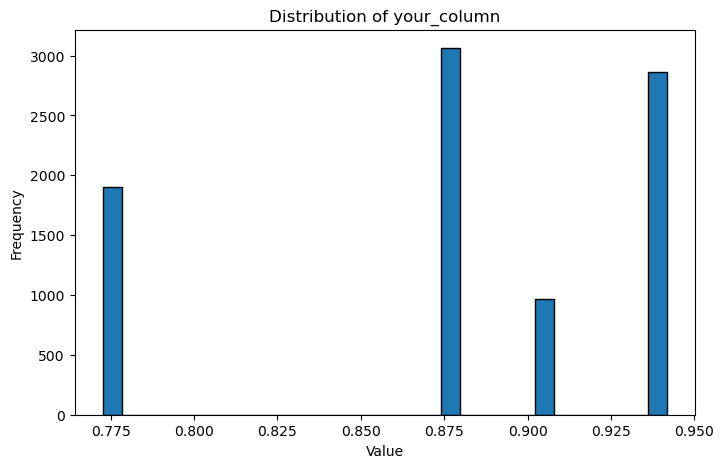

In [28]:
df["sentiment_score"].plot(kind="hist", bins=30, edgecolor="black", figsize=(8, 5), title="Distribution of your_column")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [29]:
temp = df[df["deal_stage"].isin(["Won", "Lost"])]
modelling_data = temp[['product','sector','year_established','revenue','employees','office_location','sentiment_score','deal_stage']]
modelling_data.describe()

,year_established,revenue,employees,sentiment_score
count,6711.000000,6711.000000,6711.000000,6711.000000
mean,1995.403815,2520.212707,5808.018626,0.878580
std,9.190805,2627.849922,6903.156013,0.061921
min,1979.000000,4.540000,9.000000,0.772677
25%,1988.000000,647.180000,1238.000000,0.876517
50%,1995.000000,1698.200000,3502.000000,0.876517
75%,2002.000000,3027.460000,8274.000000,0.941683
max,2017.000000,11698.030000,34288.000000,0.941683


In [30]:
modelling_data['deal_stage'] = modelling_data['deal_stage'].map({'Won': True, 'Lost': False})
modelling_data = modelling_data.rename(columns={'deal_stage': 'target'})
modelling_data.head()

C:\Users\alexa\AppData\Local\Temp\ipykernel_21188\4251007769.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modelling_data['deal_stage'] = modelling_data['deal_stage'].map({'Won': True, 'Lost': False})


,product,sector,year_established,revenue,employees,office_location,sentiment_score,target
0,Fire HD 8 Tablet with Alex...,retail,2001.0,718.62,2448.0,United States,0.941683,True
1,"All-New Fire HD 8 Tablet, ...",medical,2002.0,3178.24,4540.0,United States,0.941683,True
2,"Fire Kids Edition Tablet, ...",retail,2001.0,718.62,2448.0,United States,0.876517,True
3,"Fire Tablet with Alexa, 7 ...",software,1998.0,2714.90,2641.0,United States,0.772677,True
4,"Fire Tablet with Alexa, 7 ...",services,1982.0,792.46,1299.0,United States,0.772677,True


# Part 4 - Building a predictive model for sales Wins

#### Preparing the data for the model 

In [31]:
# Preparing data for the model training
X = modelling_data.drop('target', axis=1)
y = modelling_data['target']

# Split data: 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#### Now using ensemble model which is combination of Logistic Regression, RandomForests and GradientBoost

In [32]:
cat_cols = ['product','sector','office_location']
num_cols = ['year_established','revenue','employees','sentiment_score']

# Preprocessing
pre = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
        ('num', 'passthrough', num_cols),
    ]
)

# Base learners
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42))
    #('ab_clf', AdaBoostClassifier(random_state=42,algorithm='SAMME'))
]

# Meta model (final combiner)
final_estimator = LogisticRegression()

# Stacking classifier
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator, 
    passthrough=False  #  original features exlcuded
)

# Full ensemble model 
model = Pipeline([
    ('pre', pre),
    ('stack', stack)
])

model.fit(X_train, y_train)
joblib.dump(model, "ensemble_pipeline.joblib")

print ('Train & validation success rate', model.score(X_train, y_train),model.score(X_val, y_val))

Train & validation success rate 0.6315201192250373 0.6314221891288161


### Checking the results

#### Let's have a look at the underlying structure of the model starting with final estimator...

In [33]:
import numpy as np
import pandas as pd

stack = model.named_steps['stack']
meta = stack.final_estimator_

# Determine meta-feature names
base_names = [name for name, _ in stack.estimators]
meta_feature_names = [f"{n}_proba" for n in base_names]

# Coefficients
coef = meta.coef_.ravel()
intercept = meta.intercept_[0]

weights = pd.Series(coef, index=meta_feature_names).sort_values(ascending=False)

print("Intercept:", intercept)
print("\nMeta-model weights (higher -> more influence):")
print(weights)

Intercept: 1.026676149653994

Meta-model weights (higher -> more influence):
rf_proba    0.228467
gb_proba   -0.999474
dtype: float64


#### ... and now let's see underlying decision trees for base learners

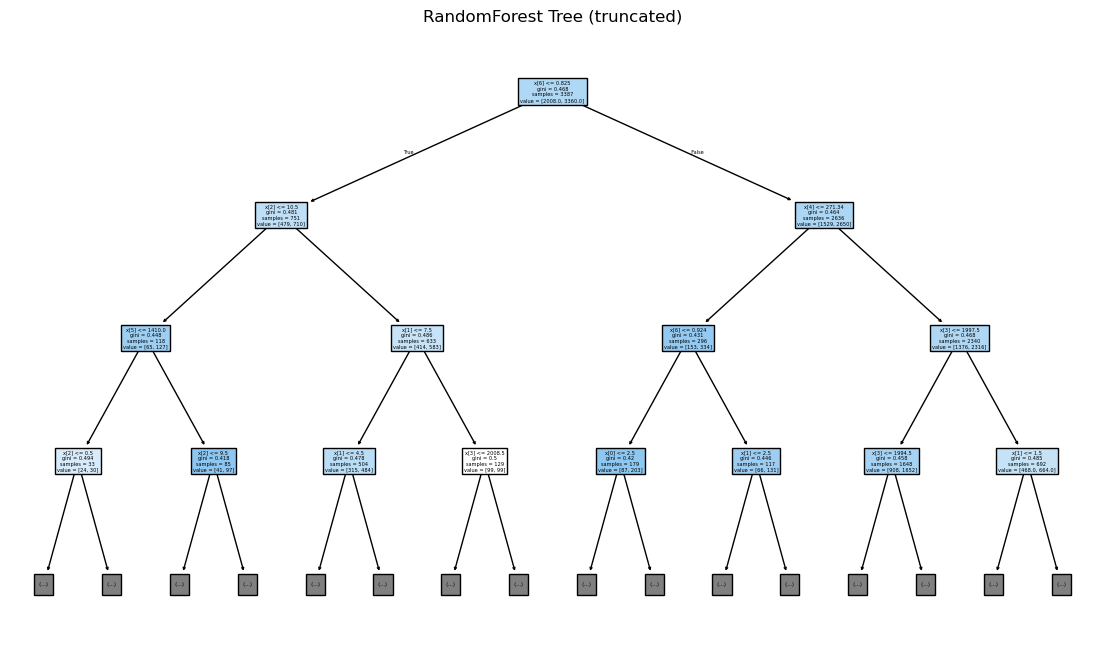

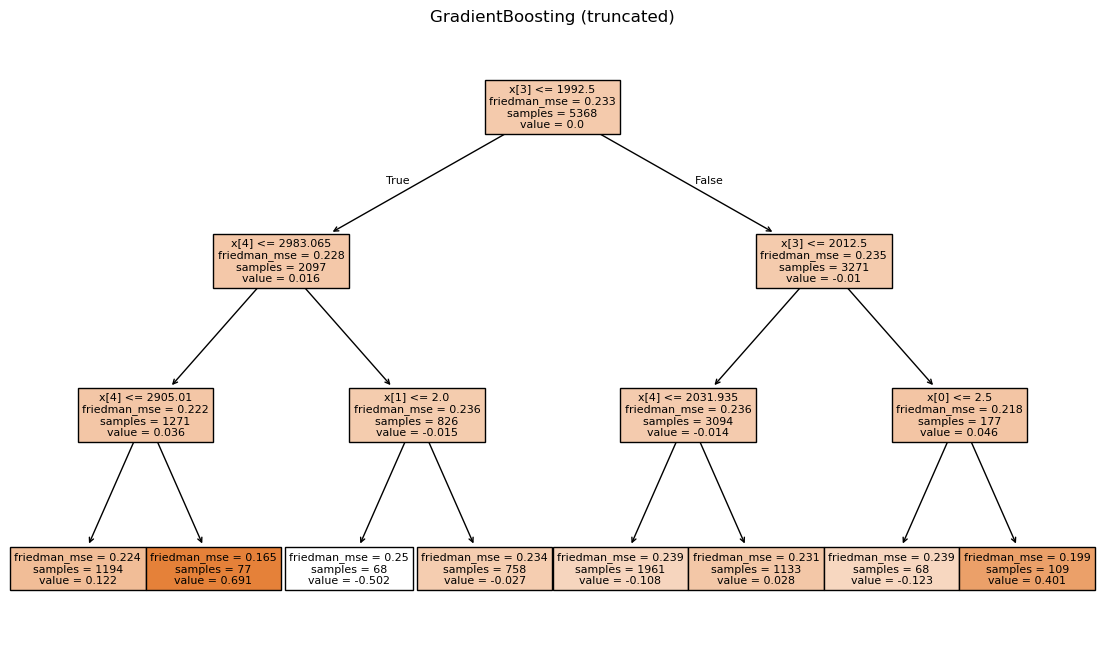

In [34]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# RandomForest: visualize first tree
rf = stack.named_estimators_['rf']  
fig = plt.figure(figsize=(14, 8))
plot_tree(rf.estimators_[0], filled=True, max_depth=3)  # limit depth for readability
plt.title("RandomForest Tree (truncated)")
plt.savefig("rf_tree.svg", format='svg', bbox_inches='tight')
plt.show()

# GradientBoosting: visualize first stage tree
gb = stack.named_estimators_['gb']       
fig = plt.figure(figsize=(14, 8))
plot_tree(gb.estimators_[0, 0], filled=True, max_depth=3)
plt.title("GradientBoosting (truncated)")
plt.savefig("gb_tree.svg", format='svg', bbox_inches='tight')
plt.show()

# Conclusion: predicting top 3 opportunities that each sales rep need to prioritise

#### Let's see how many deals are still open (no close_date)

In [35]:

df = sales_pipeline_data_enhanced
open_deals = df["close_date"].isna().sum()
print("Number of Deals Still Open",open_deals)

Number of Deals Still Open 2089


#### However some of those deals dont have enough inputs, so let's filter only those that can be analysed

In [36]:
temp1 = df[df["deal_stage"].isin(["Engaging", "Prospecting"])]
prod_data = temp1[['product','sector','year_established','revenue','employees','office_location','sentiment_score','opportunity_id','sales_agent']].dropna()
prod_sales_rep_data = prod_data[['opportunity_id','sales_agent']]
prod_data = prod_data.drop(['opportunity_id','sales_agent'], axis=1)
prod_data

,product,sector,year_established,revenue,employees,office_location,sentiment_score
25,"Fire Kids Edition Tablet, ...",retail,1995.0,5158.71,17479.0,Japan,0.876517
64,"Fire Tablet with Alexa, 7 ...",services,2003.0,692.19,1922.0,United States,0.772677
79,"Fire Tablet with Alexa, 7 ...",entertainment,1993.0,4269.90,6472.0,United States,0.772677
85,"Fire Kids Edition Tablet, ...",medical,2004.0,1618.89,3889.0,United States,0.876517
89,Fire HD 8 Tablet with Alex...,retail,1989.0,1388.67,3583.0,United States,0.941683
...,...,...,...,...,...,...,...
8761,"Fire Kids Edition Tablet, ...",marketing,1985.0,375.43,1190.0,United States,0.876517
8762,"Fire Kids Edition Tablet, ...",finance,1994.0,355.23,853.0,United States,0.876517
8763,"Fire Kids Edition Tablet, ...",technolgy,1983.0,1008.06,1238.0,United States,0.876517
8790,"Fire Kids Edition Tablet, ...",retail,1995.0,5158.71,17479.0,Japan,0.876517


#### Now let's apply the model to those opportunities

In [37]:
#Loading the model built previously
pipe_prod = joblib.load("ensemble_pipeline.joblib")
preds = pipe_prod.predict_proba(prod_data)
prod_predictions = pd.DataFrame(preds)
prod_predictions = prod_predictions.rename(columns={0: 'Predicted Loss',1:'Predicted Win'})
prod_predictions

,Predicted Loss,Predicted Win
0,0.358080,0.641920
1,0.363621,0.636379
2,0.368483,0.631517
3,0.378538,0.621462
4,0.374662,0.625338
...,...,...
659,0.367128,0.632872
660,0.365379,0.634621
661,0.375356,0.624644
662,0.358080,0.641920


In [38]:
#Combining list of opportunities with the list of predicted wins
prod_sales_rep_data = prod_sales_rep_data.reset_index(drop=True) # we are relying on the same order here (!)
prod_sales_recommendation_data =  pd.concat([prod_predictions,prod_sales_rep_data], axis=1)  
prod_sales_recommendation_data

,Predicted Loss,Predicted Win,opportunity_id,sales_agent
0,0.358080,0.641920,UP409DSB,Maureen Marcano
1,0.363621,0.636379,0DRC1U9Q,Maureen Marcano
2,0.368483,0.631517,M7I5O9YU,Corliss Cosme
3,0.378538,0.621462,VDIU10RV,Markita Hansen
4,0.374662,0.625338,579LZ3F9,Daniell Hammack
...,...,...,...,...
659,0.367128,0.632872,VW8CEV4C,Versie Hillebrand
660,0.365379,0.634621,KLUS7RVS,Versie Hillebrand
661,0.375356,0.624644,ROM4I2T0,Versie Hillebrand
662,0.358080,0.641920,FCNN6UY0,Versie Hillebrand


#### Finally. let's display the results for the stakeholders in sales management - top 3 deals for each rep

In [39]:
def summarize_top_opportunities(df, n=3):
    df = df.sort_values(['sales_agent', 'Predicted Win'], ascending=[True, False])

    def top_n_summary(x):
        topn = x.nlargest(n, 'Predicted Win')
        data = {}
        for i, (_, row) in enumerate(topn.iterrows(), start=1):
            data[f'opportunity_{i}'] = row['opportunity_id']
            data[f'predicted_win_{i}'] = row['Predicted Win']
        return pd.Series(data)

    grouped = df.drop(columns=['sales_agent']).groupby(df['sales_agent'])
    return grouped.apply(top_n_summary).reset_index().fillna('-')
    
top3_summary = summarize_top_opportunities(prod_sales_recommendation_data,n=3)
top3_summary

,sales_agent,opportunity_1,predicted_win_1,opportunity_2,predicted_win_2,opportunity_3,predicted_win_3
0,Anna Snelling,RSY2XLKK,0.649856,OEG8QG42,0.649432,DNBR1VHP,0.647455
1,Boris Faz,EZVKSQ9C,0.654353,5P3NH791,0.646863,QU220OFI,0.641783
2,Cassey Cress,37UCYEDY,0.656096,YM8DBAFV,0.652173,SY61BAXZ,0.647002
3,Cecily Lampkin,OT5G3M9A,0.640034,DS5HZHDA,0.639164,9BM1CGBV,0.634888
4,Corliss Cosme,WZN26QZQ,0.649089,RY6T3GLC,0.644832,CX0SXNCN,0.641951
5,Daniell Hammack,EFIR7HGR,0.646205,XYLNH45V,0.642022,Z9S1ZX7W,0.641462
6,Darcel Schlecht,1976N63N,0.650699,9Z2WTTNY,0.647524,EYR5E7LO,0.647294
7,Elease Gluck,DJMPI9TO,0.677151,GZCWM6GK,0.649221,125VIRMX,0.648945
8,Gladys Colclough,ICG3THQK,0.652173,KFSKQ291,0.651180,JQBN7PXK,0.648558
9,Hayden Neloms,HB740BLB,0.647455,GRYHHER0,0.643055,JCPQZ2SN,0.641121
